In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets

from inv_vae.utils.helpers import Namespace, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

load and check sample data 

In [12]:
n_rois = 68
count_offset = 100
data_path = 'sample_data/hcp_data.npy'
brain_networks, traits, translations, rotations, avg_trans, avg_rotat = preprocess_neural_data(data_path)
n_subs = brain_networks.shape[0]
motion = np.concatenate([avg_trans, avg_rotat])
print(brain_networks.shape)
print(traits.shape)
print(translations.shape)
print(avg_trans.shape)

(1065, 4624)
(1065, 175)
(1065, 17)
(1065, 1)


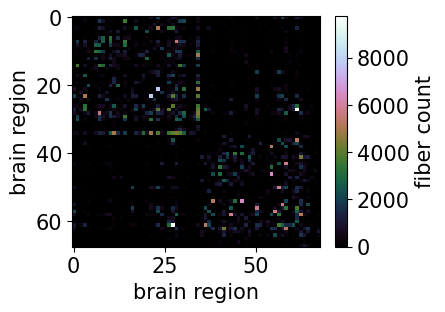

In [13]:
# check brain adjacency matrix

plt.figure(figsize=(4, 3))
plt.imshow(brain_networks.mean(0).reshape(n_rois, n_rois)*count_offset, aspect='auto', cmap='cubehelix')
plt.xlabel('brain region')
plt.ylabel('brain region')
plt.colorbar(label='fiber count')
plt.show()

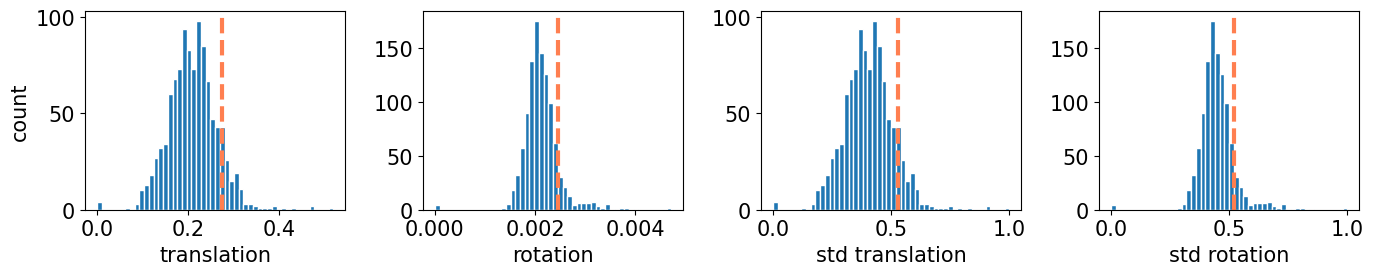

In [5]:
# check motion and rescale motion
std_trans = min_max_standardize(avg_trans)
std_rotat = min_max_standardize(avg_rotat)

fig, axes = plt.subplots(1,4,figsize=(14,3))
axes[0].hist(avg_trans, 50, edgecolor='white')
axes[0].axvline(x=np.quantile(avg_trans, .9), color='coral', ls='dashed', lw=3)
axes[0].set_xlabel('translation')
axes[0].set_ylabel('count')
axes[1].hist(avg_rotat, 50, edgecolor='white')
axes[1].axvline(x=np.quantile(avg_rotat, .9), color='coral', ls='dashed', lw=3)
axes[1].set_xlabel('rotation')
axes[2].hist(std_trans, 50, edgecolor='white')
axes[2].axvline(x=np.quantile(std_trans, .9), color='coral', ls='dashed', lw=3)
axes[2].set_xlabel('std translation')
axes[3].hist(std_rotat, 50, edgecolor='white')
axes[3].axvline(x=np.quantile(std_rotat, .9), color='coral', ls='dashed', lw=3)
axes[3].set_xlabel('std rotation')
plt.tight_layout()
plt.show()

model fitting

In [7]:
# model config

config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.,
    alpha = 1, beta = .1, gamma = 1, add_reg = False, y_dim = 0, 
    batch_size=32, n_epochs=100, lr=1e-5, device=DEVICE)

In [14]:
# prepare torch datasets for training

ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)

train_set = utils.TensorDataset(tensor_nets[train_ids], 
                        tensor_motion[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], 
                        tensor_motion[val_ids] )

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

958 107


In [17]:
# create masks for graph convolution layers

A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]
print(len(knn_masks), knn_masks[0].shape)

5 torch.Size([68, 68])


vae

In [18]:
model = VAE(config).to(config.device)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [ ]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.custom_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.custom_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: -315.643 nll: -331.069 kl: 154.259
epoch: 0 test loss -5788.853 nll: -5808.009 kl: 191.566
epoch: 5 train loss: -16803.195 nll: -16806.420 kl: 32.252
epoch: 5 test loss -17079.670 nll: -17082.182 kl: 25.120
epoch: 10 train loss: -16879.339 nll: -16881.311 kl: 19.718
epoch: 10 test loss -17141.283 nll: -17143.438 kl: 21.553
epoch: 15 train loss: -16902.251 nll: -16904.761 kl: 25.099
epoch: 15 test loss -17162.414 nll: -17165.488 kl: 30.748
epoch: 20 train loss: -16915.906 nll: -16919.601 kl: 36.952
epoch: 20 test loss -17175.782 nll: -17180.164 kl: 43.825
epoch: 25 train loss: -16927.975 nll: -16933.515 kl: 55.399
epoch: 25 test loss -17188.872 nll: -17195.220 kl: 63.471


In [ ]:
# diagnostics
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)
plt.show()

In [ ]:
# torch.save(model.state_dict(), './pretrained/hcp_vae_pretrained.mod')
# model.load_state_dict(torch.load('./pretrained/hcp_vae_pretrained.mod'))

In [ ]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 5, replace=False)]):
    p = axes[i].imshow(x, aspect='auto', cmap='Blues', vmin=0, vmax=2)
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  